<a href="https://colab.research.google.com/github/FinnHendricks/YOLO_ConeDetection/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FinnHendricks/YOLO_ConeDetection/blob/main/train.ipynb)

In [1]:
partial_dataset = True
load_model = False

from google.colab import drive
drive.mount('/content/gdrive')

model_path = "/content/gdrive/MyDrive/YOLO_cone/model"

Mounted at /content/gdrive



## Steps:
- basic CNN architecture / class - ok
- input pipeline - ok
- visualisation - ok
- IoU - ok
- 2 BB per cell
- Loss function
- non maxima suppression
- Train/optimizer
- training
- better architecture, batch_norm
- augmentation

- result: sigmoid on center + exponent of w+h

## General steps:
- Yolo on cones / on COCO
- introduce different scales
- Yolo on COCO
- introduce anchor boxes
- CARLA data
- Yolo on Carla

## yolo-format (called label(s) in this notebook:
- each image has its own label file with the same file name
- each cone of an image is described by one line
- Format in txt files: class, x_center, y_center, width_bbox, height_bbox
- Format used in this notebook: [objectness, x_center, y_center, width_bbox, height_bbox, class0, c1, c2, c3, c4, c5, c6]

- 0 blue
- 1 yellow
- 2 orange-small
- 3 orange-big (shown in red)
- 4 yellow-big (shown in white)
- 5 green
- 6 lying

## YOLO-Output (called y / y_pred / y_true in this notebook:

Per S x S grid cell, e.g. 8x8:
x,y, height, width, objectness, prob per class

--> 8x8x(4+1+7) = 8x8x12 = 768 output neurons


In [2]:
!pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 8.0 MB/s 


In [97]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD

import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

print(tf.config.list_physical_devices())
print(tf.__version__)

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.6.0
Sun Oct 17 15:45:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    32W / 250W |   5669MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+----------------------------

In [98]:
%%capture
if partial_dataset:
    !unzip -u "/content/gdrive/MyDrive/cones_multi_class_partial.zip" -d "/content/";
    directory_train = '/content/cones_multi_class_partial/train'
    directory_test = '/content/cones_multi_class_partial/test/'
    train_size = 128
    batch_size = 8
else:
    !unzip -u "/content/gdrive/MyDrive/cones_multi_class.zip" -d "/content/";
    directory_train = '/content/cones_multi_class/train'
    directory_test = '/content/cones_multi_class/test/'
    train_size = 21_067 - 14  
    batch_size = 32

In [99]:

img_width = 512#800
img_height = 512#320
img_channels = 3

grid_X = 16
grid_Y = 16
num_classes = 7  # blue, yellow, orange_small, o_big, yellow, green, lying
anchor_size = num_classes + 5

epochs = 5
initial_learning_rate = 0.01
#final_learning_rate = 0.001
#learning_rate_decay_factor = (final_learning_rate / initial_learning_rate) ** (1/epochs)
steps_per_epoch = int(train_size/batch_size)


In [100]:
# convert the label given in the csv files to a matrix that can be used as y

def convert_label_to_y(label, file):
    object_class, x_center, y_center, width_bbox, height_bbox = list(map(float, label))

    # find relevant grid cell for predicting the object
    i, j = int(y_center * grid_Y), int(x_center * grid_X) # i row, j column 

    assert i < grid_Y, "center must be within the image" + str(file.name)
    assert j < grid_X, "center must be within the image" + str(file.name)

    x_center_bbox = x_center * grid_X - j  # find center relative to cell; 0...1
    y_center_bbox = y_center * grid_Y - i

    width_bbox *= grid_X  # scale box size, that 1 equals the grid size -> range of object size makes more sense
    height_bbox *= grid_Y

    c0, c1, c2, c3, c4, c5, c6 = tf.one_hot(tf.range(7), 7)[int(object_class)] # class of the cone
    # objectness, x_center, y_center, width_bbox, height_bbox, class0, c1, c2, c3, c4, c5, c6
    y = [1.0, x_center_bbox, y_center_bbox, width_bbox, height_bbox, c0, c1, c2, c3, c4, c5, c6]
    return y, i, j

In [101]:
black_list_files_train = ["00001505_skid-pad.txt", 
                    "Renningen_08_04_video_second_frame_8.txt", 
                    "Aidlingen_07_12_video_first_frame_4.txt",
                    "Aidlingen_07_12_video_first_frame_8.txt",
                    "upbracing-classes.txt",
                    "00001833_skid-pad.txt",
                    "00047.txt",
                    "Aidlingen_07_12_video_first_frame_7.txt",
                    "00001465_skid-pad.txt",
                    "Aidlingen_07_12_video_first_frame_5.txt",
                    "Aidlingen_07_12_video_first_frame_6.txt",
                    "213(2).txt",
                    "Aidlingen_07_12_video_first_frame_3.txt",
                    "00001464_skid-pad.txt"
                    ]  
                    # the labels of this samples are currupt and may not be used

black_list_files_test = []

def read_data(path, black_list_files=None):
    if black_list_files is None:
        black_list_files = []
    jpg_paths = []
    n_samples = 0
    for file in os.listdir(path):
        if file.endswith(".txt"):
            n_samples += 1
    n_samples -= len(black_list_files)

    sample_ctr = 0
    y = np.zeros((n_samples, grid_X, grid_Y, anchor_size))
    for file in os.listdir(path):
        if file.endswith(".txt"):
          
            if file in black_list_files:
                continue
            #try:
            with open(os.path.join(path, file), "r") as file:
                for label in file:
                    label = label.strip().split(" ")
                    cone, i, j = convert_label_to_y(label, file) 
                    
                    if y[sample_ctr, j, i, 0] == 0:
                        # no cone is stored at the grid cell, yet
                        y[sample_ctr, j, i, :] = cone
                    # else:
                        # slot already full- don´t write the cone
                        # print("No space to store the cone. Cone will be dismissed. File: ", file.name, i,j)
                        # think about dismissing the whole image and don´t use it for training
                        
            #except:
            #    print(str(file))
            #    continue
            #find the corresponding image path
            jpg_path = file.name.strip("txt")+"jpg"
            jpg_paths.append(jpg_path)
            sample_ctr += 1
            
    return jpg_paths, y

if partial_dataset:
    jpg_paths_train, y_train = read_data(directory_train)
    jpg_paths_test, y_test = read_data(directory_test)  
else:           
    jpg_paths_train, y_train = read_data(directory_train, black_list_files_train)
    jpg_paths_test, y_test = read_data(directory_test)
print(y_train.shape[0], " train images found.")
print(y_test.shape[0], " test images found.")



128  train images found.
32  test images found.


In [102]:
# input data

ds_train = tf.data.Dataset.from_tensor_slices((jpg_paths_train, y_train))
ds_test = tf.data.Dataset.from_tensor_slices((jpg_paths_test, y_test))

def read_image(image_file, y):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels=3)#, dtype=tf.float32)
    return image, y

def resize(image, y):
    image = tf.image.resize(image, [img_height, img_width], method=tf.image.ResizeMethod.BILINEAR,preserve_aspect_ratio=False)
    image = image / 255. # rescale
    return image, y


#ds_train = ds_train.map(read_image).map(resize_and_crop).map(augment).batch(batch_size)
ds_train = ds_train.map(read_image).map(resize).shuffle(train_size).batch(batch_size).prefetch(2)
ds_test = ds_test.map(read_image).map(resize).batch(batch_size)




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


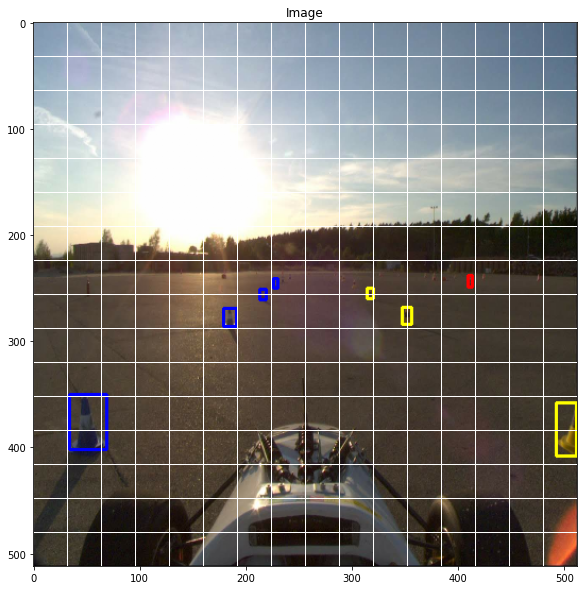

In [152]:
def visualize(image):
    fig = plt.figure(figsize=(10,10))
    plt.title('Image')
    plt.imshow(image)


def draw_bounding_box(image, y, draw_grid=True):
    image = image.numpy()
    h, w, _ = image.shape   
        
    relevant_grids = np.argwhere(y[:,:,0] >= 0.3)  # get relevant grids that contain objects with objectness > 0.3 
    for grid in relevant_grids:
        objectness, x_center_bbox, y_center_bbox, width_bbox, height_bbox = y[list(grid)][:5]
        #blue, yellow, orange, orange-big, yellow-big, green, lying
        object_class = y[list(grid)][5:]
        object_class = np.argmax(object_class) 

        #Todo: class when not 0 / 1
        colors = {
            0: [0, 0, 255],
            1: [255, 255, 0],
            2: [255, 165, 0],
            3: [255, 0  , 0],
            4: [255, 255, 255],
            5: [0  , 255, 0],
            6: [0  , 0  , 0]
        }
        color = colors[object_class]
        color = color * objectness  # adjust brightness based on objectness

        color = tf.make_tensor_proto(color)
        color = tf.make_ndarray(color).astype(int).tolist()
    
        x_center = (x_center_bbox + grid[0])/grid_X*w
        y_center = (y_center_bbox + grid[1])/grid_Y*h
        box_width = width_bbox / grid_X * w
        box_height = height_bbox / grid_Y * h
        
        x_min = int(x_center - box_width/2)
        x_max = int(x_center + box_width/2)
        y_min = int(y_center - box_height/2)
        y_max = int(y_center + box_height/2)
        
        image = cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, 2) 
        if draw_grid:
            grid_points = [[(int(i/grid_X*w), 0),(int(i/grid_X*w), h)]for i in range(grid_X)] + \
                          [[(0, int(i/grid_Y*h)),(w, int(i/grid_Y*h))]for i in range(grid_Y)]
            for points in grid_points: 
                cv2.line(image, points[0], points[1], [255, 255, 255], 1) 

    return image

for images, y in ds_train:
    #print(images.shape)
    i = np.random.randint(0, batch_size)
    image = draw_bounding_box(images[i], y[i], draw_grid=True)
    visualize(image)
    break

In [114]:
input_layer = keras.layers.Input(shape=(img_width, img_height, img_channels))
x = keras.layers.Conv2D(16, (3, 3), strides=(2,2), activation='relu', padding='same')(input_layer)
x = keras.layers.Conv2D(32, (3, 3), strides=(1,1), activation='relu', padding='same')(x)
x = keras.layers.Conv2D(64, (3, 3), strides=(2,2), activation='relu', padding='same')(x)
x = keras.layers.Conv2D(64, (3, 3), strides=(2,2), activation='relu', padding='same')(x)
x = keras.layers.Conv2D(64, (3, 3), strides=(1,1), activation='relu', padding='same')(x)
x = keras.layers.Conv2D(128, (3, 3), strides=(2,2), activation='relu', padding='same')(x)
x = keras.layers.Conv2D(128, (3, 3), strides=(1,1), activation='relu', padding='same')(x)
x = keras.layers.Conv2D(128, (3, 3), strides=(2,2), activation='relu', padding='same')(x)
x = keras.layers.Conv2D(64, (1, 1), strides=(1,1), activation='relu', padding='same')(x)
# using just a single anchor
out_channels = anchor_size  # [objectness, x_center, y_center, width_bbox, height_bbox, class0, c1, c2, c3, c4, c5, c6]
x = keras.layers.Conv2D(out_channels, (1, 1), strides=(1,1), activation='linear', padding='same')(x)




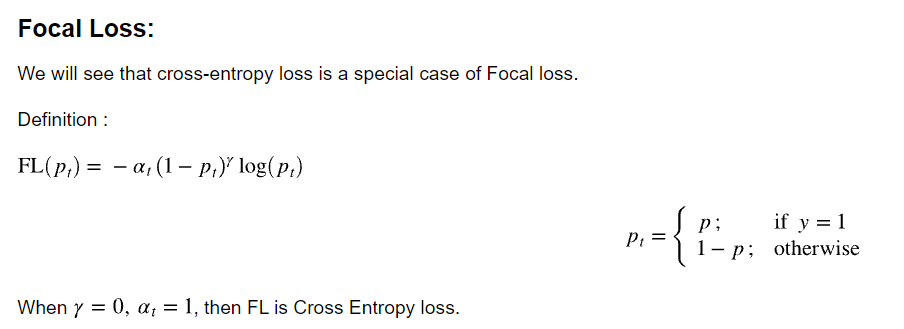

In [210]:

def loss_yolo_v1(y, y_pred):
   
    # with this L2 loss as a start you can start overfitting on a small dataset to check if your setup works in general
    # works if BBoxPerGrid = 1, for BBoxPerGrid = 3 y is too sparse and the CNN doesn´t learn anymore!!
    # more sophisticated loss function is required
    #loss = keras.losses.mean_squared_error(y, y_pred) 

    

    # objectness
    #sigmoid_CE = tfa.losses.SigmoidFocalCrossEntropy(gamma=10) # alpha=0.1)
    #
    #obj_loss = sigmoid_CE(y[...,0], y_pred[...,0])  # y[...,0] adresses all objectness scores
    #loss = obj_loss

    # bboxes as GIoU

    # as a start getting ones:
    #rest_loss = keras.losses.mean_squared_error(tf.ones_like(y_pred[...,1:]), y_pred[...,1:]) 
    #loss = obj_loss #+ rest_loss

    #bce = tf.keras.losses.BinaryCrossentropy()
    mse = tf.keras.losses.MeanSquaredError()
    obj_weight = tf.ones_like(y[...,0])*0.01 + y[...,0]*100
    #print(sample_weight.shape, y.shape, y[...,0].shape)
    obj_loss = mse(y[...,0], y_pred[...,0])*obj_weight

    box_weight = [y[...,0],y[...,0],y[...,0],y[...,0]]
    box_weight = tf.stack(box_weight, axis=3)
    box_loss = mse(y[...,1:5], y_pred[...,1:5])*box_weight


    loss = tf.math.reduce_sum(obj_loss) + tf.math.reduce_sum(box_loss)
    # -----------------------------------------------------------------------

    # first, find a mapping for each grid cell, which anchor 
    # objectness for each grid cell -> required to surpress ghost objects


    # x/y/w/h as GIoU only where y_pred has an object
    # select which bbox_pred belongs to which bbox_true based on minimizing the overall GIoU
    
    # class prob. only where y_pred has an object
    # other than in the paper, classes should be available for each object

    """# loss for predicting objects where no objects are
    bce = tf.keras.losses.BinaryCrossentropy()
    # I skip this for now and just penalize all predictions (weight norm penalty using L1 Loss -> enforce sparsity)


    # loss for not predicting the objectness 
    obj_loss = bce(y[...,0], y_pred[...,0])  # y[...,0] adresses all objectness scores

    # loss for the box
    # mse for center point
    center_loss = tf.keras.losses.mean_squared_error(y[...,1:3], y_pred[...,1:3]) * y[...,0]
    
    # mse of sqrt for width/height
    box_loss = tf.keras.losses.mean_squared_error(tf.math.sqrt(tf.maximum(y[...,3:5],0)), 
                                                  tf.math.sqrt(tf.maximum(y_pred[...,3:5],0))) * y[...,0]   
    
    #print("start")
    #tf.print(tf.keras.losses.mean_squared_error(y[...,1:3], y_pred[...,1:3]).shape)
    #tf.print(y[...,0].shape)
    #tf.print((tf.keras.losses.mean_squared_error(y[...,1:3], y_pred[...,1:3]) * y[...,0]).shape)
    
    # loss for the class
    class_loss = tf.keras.losses.mean_squared_error(y[...,5:], y_pred[...,5:]) * y[...,0]

    # regularization
    regularization_lasso = 0#tf.keras.losses.mean_absolute_error(y_pred, tf.zeros_like(y_pred))

    loss = obj_loss + center_loss + box_loss + class_loss + 0.01*regularization_lasso"""
    #gl = tfa.losses.GIoULoss()
    #boxes1 = tf.constant([[0.0, 0.0, 1.0, 1.0]])#, [5.0, 6.0, 10.0, 7.0]])
    #boxes2 = tf.constant([[-5.0, -5.0, -2.0, -2.0]])#, [14.0, 14.0, 15.0, 15.0]])
    #loss = gl(boxes1, boxes2)
    #print(loss)
    return loss


In [211]:
# Instantiate the model

if load_model:
    model = keras.models.load_model(model_path, custom_objects={'loss_yolo_v1': loss_yolo_v1})

else:
    model = keras.Model(inputs=input_layer, outputs=x)
    opt = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss=loss_yolo_v1)

print(model.summary())

Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 256, 256, 16)      448       
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 256, 256, 32)      4640      
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 32, 32, 128)       738

In [212]:
model.fit(
    ds_train,
    epochs=50,
    verbose=2,
    # Only run validation using the first 10 batches of the dataset
    # using the `validation_steps` argument
    validation_data=ds_test,
    validation_steps=1
)
model.save(model_path)

Epoch 1/50
16/16 - 4s - loss: 142.2898 - val_loss: 62.6333
Epoch 2/50
16/16 - 3s - loss: 131.3195 - val_loss: 48.5254
Epoch 3/50
16/16 - 3s - loss: 127.8599 - val_loss: 56.3616
Epoch 4/50
16/16 - 3s - loss: 125.2108 - val_loss: 55.5676
Epoch 5/50
16/16 - 3s - loss: 122.2030 - val_loss: 58.9878
Epoch 6/50
16/16 - 3s - loss: 120.1828 - val_loss: 57.9248
Epoch 7/50
16/16 - 3s - loss: 120.4474 - val_loss: 58.8972
Epoch 8/50
16/16 - 3s - loss: 123.8065 - val_loss: 74.2015
Epoch 9/50
16/16 - 3s - loss: 125.1264 - val_loss: 62.7139
Epoch 10/50
16/16 - 3s - loss: 121.4537 - val_loss: 52.6932
Epoch 11/50
16/16 - 3s - loss: 118.3914 - val_loss: 91.6649
Epoch 12/50
16/16 - 3s - loss: 117.6011 - val_loss: 59.9644
Epoch 13/50
16/16 - 3s - loss: 115.6882 - val_loss: 57.2371
Epoch 14/50
16/16 - 3s - loss: 115.4865 - val_loss: 62.0663
Epoch 15/50
16/16 - 3s - loss: 114.8256 - val_loss: 69.3631
Epoch 16/50
16/16 - 3s - loss: 116.5479 - val_loss: 63.5451
Epoch 17/50
16/16 - 3s - loss: 116.7914 - val_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


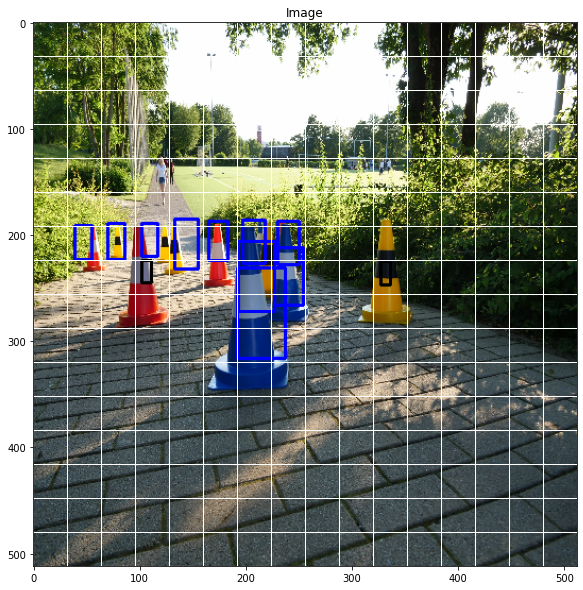

In [213]:
y_pred = 0
for images, y in ds_train:
    #print(images.shape)
    y_pred = model.predict(images)
    image = draw_bounding_box(images[0], tf.convert_to_tensor(y_pred[0]), draw_grid=True)
    visualize(image)
    break

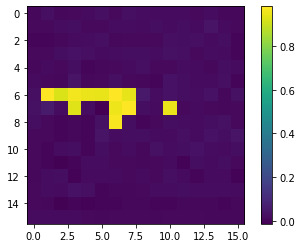

In [214]:
plt.imshow(y_pred[0,:,:,0].T)
plt.colorbar()

In [172]:
tf.repeat(y[...,0], 4, axis=-1).shape

TensorShape([8, 16, 64])

In [170]:
y[...,0].shape

TensorShape([8, 16, 16])

In [201]:
l = [y[...,0],y[...,0],y[...,0],y[...,0]]
tf.stack(l, axis=3).shape

TensorShape([8, 16, 16, 4])

In [186]:
tf.ones_like(y[...,0:4]).shape

TypeError: ignored